In [2]:
import h5py
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from matplotlib import animation
import pde
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error

from IPython.display import Video

In [3]:
## LOAD DATA ## 

x_s=2*np.sqrt(2)
d=0
mu=0.1

filename = f'./Data/Simulations/double_well_xs_{x_s:.3f}_d_{d:.3f}_mu_{mu:.1f}.h5'
data = h5py.File(filename)

t = np.array(data['times'])
dt = t[1]-t[0]

x = np.array(data['x'])
dx = x[1]-x[0]

u = np.array(data['data'])
u_dot = ps.FiniteDifference(axis=0)._differentiate(u, t=dt)

data.close()



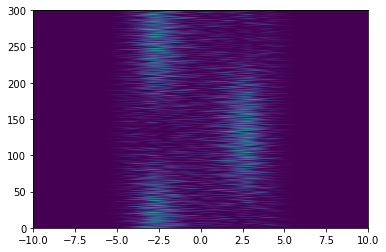

In [3]:
plt.pcolormesh(x, t, np.abs(u)**2)

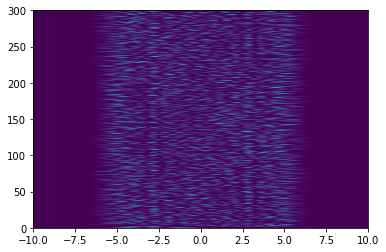

In [4]:
plt.pcolormesh(x, t, np.abs(u_dot)**2)

In [4]:
## GET REAL AND IMG PART TO USE WITH SINDY ## 

training_frac = 0.2
train_sample = int(len(t)*training_frac)
test_sample = 6000

u_real = np.real(u)
u_img = np.imag(u)

u_dot_real = np.real(u_dot)
u_dot_img = np.imag(u_dot)

u_shaped = np.zeros(shape=(len(x), len(t), 3))
u_shaped[:,:, 0]=u_real.T
u_shaped[:,:, 1]=u_img.T
u_shaped[:,:, 2]=np.tile(x,(len(t),1)).T # add x values to pass to u and u_dot (in these way one can introduce spatial potential terms)

u_dot_shaped = np.zeros(shape=(len(x), len(t), 2))
u_dot_shaped[:,:, 0]=u_dot_real.T
u_dot_shaped[:,:, 1]=u_dot_img.T
#u_dot_shaped[:,:, 2]=np.zeros_like(u_dot_shaped[:,:,1]) # np.tile(x,(train_sample,1)).T

u_dot_shaped.shape


(1000, 30001, 2)

In [5]:
## DEFINE CANDIDATES LIBRARY ## 

# 2nd order poly library
poly_library = ps.PolynomialLibrary(include_bias=False, degree=4) 

# PDE library
library_functions = [lambda x: x]
library_function_names = [lambda x: x]
pde_library = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x, 
                        include_bias=True, is_uniform=True, include_interaction=False)

# Tensor polynomial library with the PDE library
tensor_array = [[1, 1]]
inputs_temp = np.tile([0, 1, 2], 2)
inputs_per_library = np.reshape(inputs_temp, (2, 3))
inputs_per_library[1,2] = 0 # only compute PDs for psi_real and psi_img
inputs_per_library[0] = [2, 2, 2] # only compute polynomial for x input feature


generalized_library = ps.GeneralizedLibrary(
    [poly_library, pde_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

In [21]:

train_idx = 3000
reshape_train_score = u_dot_shaped[:,:train_idx,:].shape[-3]*u_dot_shaped[:,:train_idx,:].shape[-2], u_dot_shaped[:,:train_idx,:].shape[-1]
reshape_val_score = u_dot_shaped[:,-test_sample:,:].shape[-3]*u_dot_shaped[:,-test_sample:,:].shape[-2], u_dot_shaped[:,-test_sample:,:].shape[-1]


threshold_values = [1, 0.1, 0.01, 0.001, 0.0001, 0]
r2_score_train = []
r2_score_val = []
mse_train = []
mse_val = []
eq = []


for thres_val in threshold_values:    
    
    optimizer = ps.STLSQ(threshold=thres_val, verbose=True)
    model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, feature_names=['psi_r', 'psi_i', 'x'])
    model.fit(x=u_shaped[:,:train_idx,:], t=dt, x_dot=u_dot_shaped[:,:train_idx,:])
    model.print(precision=8)
    
    eq.append(model.equations(precision=16)) 
    
    r2_score_train.append(model.score(x=u_shaped[:,:train_idx,:], t=dt, x_dot=u_dot_shaped[:,:train_idx,:].reshape(reshape_train_score)))
    r2_score_val.append(model.score(x=u_shaped[:,-test_sample:,:], t=dt, x_dot=u_dot_shaped[:,-test_sample:,:].reshape(reshape_val_score)))
    
    mse_train.append(model.score(x=u_shaped[:,:train_idx,:], t=dt, x_dot=u_dot_shaped[:,:train_idx,:].reshape(reshape_train_score), metric=mean_squared_error))
    mse_val.append(model.score(x=u_shaped[:,-test_sample:,:], t=dt, x_dot=u_dot_shaped[:,-test_sample:,:].reshape(reshape_val_score), metric=mean_squared_error))
    



 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 4.4369e+05 ... 0.0000e+00 ...          0 ... 4.4369e+05
(psi_r)' = 0.00000000
(psi_i)' = 0.00000000


C:\Users\loren\anaconda3\envs\sindy\lib\site-packages\pysindy\optimizers\stlsq.py:183: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  warnings.warn(


 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 8.4042e+05 ... 3.1189e-02 ...          4 ... 8.4042e+05
         1 ... 1.4033e+05 ... 1.9024e-02 ...          2 ... 1.4033e+05
         2 ... 1.4026e+05 ... 1.8453e-02 ...          2 ... 1.4026e+05
(psi_r)' = -0.42899112 psi_i_11
(psi_i)' = 0.43014955 psi_r_11
 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 6.8213e-01 ... 3.1213e-02 ...          6 ... 7.1334e-01
         1 ... 6.4872e-01 ... 3.1220e-02 ...          6 ... 6.7994e-01
(psi_r)' = -0.49956432 psi_i_11 + -0.24978356 x^2 psi_i + 0.01561142 x^4 psi_i
(psi_i)' = 0.49956687 psi_r_11 + 0.24978744 x^2 psi_r + -0.01561161 x^4 psi_r
 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 6.8213e-01 ... 3.1213e-02 ...          6 ... 7.1334e-01
         1 ... 6.4872e-01 ... 3.1220e-02 ...          6 ... 6.7994

In [12]:
## SET BEST THRESHOLD PARAMETER FOUND AND TRAIN USING ALL TRAINING SET ## 

optimizer = ps.STLSQ(threshold=0.001, verbose=True)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, feature_names=['psi_r', 'psi_i', 'x'])
model.fit(u_shaped[:,:300,:], t=dt)
model.print()

print(generalized_library.get_feature_names(), "\n")

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 2.3502e-01 ... 3.1102e-02 ...         13 ... 2.6612e-01
         1 ... 7.3022e-02 ... 3.1207e-02 ...          6 ... 1.0423e-01
         2 ... 6.8246e-02 ... 3.1222e-02 ...          6 ... 9.9468e-02
(psi_r)' = -0.500 psi_i_11 + -0.250 x^2 psi_i + 0.016 x^4 psi_i
(psi_i)' = 0.500 psi_r_11 + 0.250 x^2 psi_r + -0.016 x^4 psi_r
(x)' = 0.000
['x2', 'x2^2', 'x2^3', 'x2^4', '1', 'x0', 'x1', 'x0_1', 'x1_1', 'x0_11', 'x1_11', 'x2 1', 'x2 x0', 'x2 x1', 'x2 x0_1', 'x2 x1_1', 'x2 x0_11', 'x2 x1_11', 'x2^2 1', 'x2^2 x0', 'x2^2 x1', 'x2^2 x0_1', 'x2^2 x1_1', 'x2^2 x0_11', 'x2^2 x1_11', 'x2^3 1', 'x2^3 x0', 'x2^3 x1', 'x2^3 x0_1', 'x2^3 x1_1', 'x2^3 x0_11', 'x2^3 x1_11', 'x2^4 1', 'x2^4 x0', 'x2^4 x1', 'x2^4 x0_1', 'x2^4 x1_1', 'x2^4 x0_11', 'x2^4 x1_11'] 



C:\Users\loren\anaconda3\envs\sindy\lib\site-packages\pysindy\optimizers\stlsq.py:193: UserWarning: Sparsity parameter is too big (0.001) and eliminated all coefficients
  warnings.warn(
C:\Users\loren\anaconda3\envs\sindy\lib\site-packages\pysindy\optimizers\stlsq.py:193: UserWarning: Sparsity parameter is too big (0.001) and eliminated all coefficients
  warnings.warn(


In [13]:
psi_r_rhs=model.equations(precision=16)[0].replace('psi_i_11', 'laplace(psi_i)').replace(' ', '*').replace('*+*', '+').replace('^','**')
psi_i_rhs=model.equations(precision=16)[1].replace('psi_r_11', 'laplace(psi_r)').replace(' ', '*').replace('*+*', '+').replace('^','**')

## for complex equation other way is
# def multipleReplace(text, wordDict):
#     for key in wordDict:
#         text = text.replace(key, wordDict[key])
#     return text

reconstructed potential:
          4          2
0.01561 x - 0.2498 x
x_max [0.]
x_min [ 2.82844987 -2.82844987]
         4        2
0.01562 x - 0.25 x - 2.22e-16


C:\Users\loren\AppData\Local\Temp\ipykernel_25100\3818853951.py:47: RuntimeWarning: invalid value encountered in true_divide
  100*np.abs(V_coeff - V_true_coeff)/np.abs(V_true_coeff)


array([8.58982201e-02,            nan, 8.42911351e-02,            nan,
       1.00000000e+02])

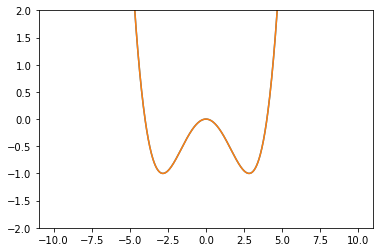

In [14]:
## COMPUTE RECONSTRUCTED POTENTIAL ##

feat_name = generalized_library.get_feature_names()
r_param = [feat_name.index('x1'), feat_name.index('x2 x1'), feat_name.index('x2^2 x1'), feat_name.index('x2^3 x1'), feat_name.index('x2^4 x1')]
i_param = [feat_name.index('x0'), feat_name.index('x2 x0'), feat_name.index('x2^2 x0'), feat_name.index('x2^3 x0'), feat_name.index('x2^4 x0')]

V_r = model.coefficients()[0][r_param]
V_i = model.coefficients()[1][i_param]

V_coeff = (V_r - V_i)/2
V_coeff = V_coeff[::-1]
V_sim = np.poly1d(V_coeff)
plt.plot(x, V_sim(x))

print('reconstructed potential:\n', V_sim)

x_crit = V_sim.deriv().r
x_min = x_crit[V_sim.deriv(2)(x_crit)>0]
x_max = x_crit[V_sim.deriv(2)(x_crit)<0]

print('x_max', x_max)
print('x_min', x_min)

## TRUE POTENTIAL ## 

m = 1 # fixed 
w = 1 # fixed 


C = m*w**2/(8*x_s**2)
x_u = d*(2*x_s**2/(m*w**2)) # maximum position
delta_V = 4*d*x_s**3/3 # between the two minima 



def V(x):
    return C*(x**2-x_s**2)**2 - d*(x**3/3-x_s**2*x)


V_true_coeff = np.array([C, -d/3, -2*C*x_s**2, d*x_s**2, C*x_s**4-V(x_u)])
V_true = np.poly1d(V_true_coeff)
print(V_true)

plt.plot(x, V_true(x))
plt.ylim(-2,2)

100*np.abs(V_coeff - V_true_coeff)/np.abs(V_true_coeff)


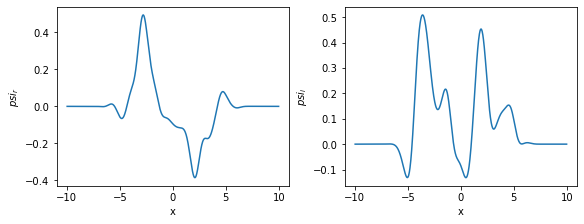

In [70]:
## FITTED MODEL SIMULATION ## 

# TO DO: GENERALIZE EQUATION WRITING FROM MODEL RESULT

# uxx_re = model.coefficients()[0,8]
# uxx_im = model.coefficients()[1,7]
# x2psi_re = model.coefficients()[0,18]
# x2psi_im = model.coefficients()[1,17]

# eq = pde.PDE({'psi_r':'{}*laplace(psi_i)+{}*x*x*psi_i'.format(uxx_re, x2psi_re), 
#               'psi_i':'{}*laplace(psi_r)+{}*x*x*psi_r'.format(uxx_im, x2psi_im)})

eq=pde.PDE({'psi_r':psi_r_rhs, 
           'psi_i':psi_i_rhs})


## DEFINE SPATIAL GRID ##

Nx = len(x) # number of spatial points
x_left = x[0]
x_right = x[-1]

grid = pde.CartesianGrid([(x_left,x_right)], Nx, periodic=False)
grid.coordinate_arrays = (x,) # this is needed otherwise endpoints are excluded

## DEFINE INITIAL STATE FOR SIMULATION (use last u entry) ##

initial_state_r = pde.ScalarField(grid, u_real[train_sample], label= '$psi_r$')
initial_state_i = pde.ScalarField(grid, u_img[train_sample], label = '$psi_i$')

initial_state = pde.FieldCollection([initial_state_r, initial_state_i])

initial_state.plot()


In [71]:
## PERFORM SIMULATION ##

# define storage 
storage = pde.MemoryStorage() # for movie and control plots

# simulation time and step (1e-6 and 1e-5 seems to work, more testing needed to se if less can be used)
t_range = t[-1]-t[train_sample]
dt_sim = 1e-5

dt_save = 0.01


solver = pde.ExplicitSolver(eq, scheme="runge-kutta", adaptive=False)
controller = pde.Controller(solver, t_range=t_range, tracker=['progress', storage.tracker(interval=dt_save)])
_ = controller.run(initial_state, dt=dt_sim)

  0%|          | 0/239.99999999987878 [00:00<?, ?it/s]

In [72]:
## COMBINE REAL AND IMAGINARY PART ## 

data_sim = np.array([storage.data[i][0]+1j*storage.data[i][1] for i in range(len(storage))])
storage_sim = pde.MemoryStorage(times=t[train_sample]+np.array(storage.times), data=data_sim, field_obj=pde.ScalarField(grid, label='$psi_sim$', dtype=np.complex128))


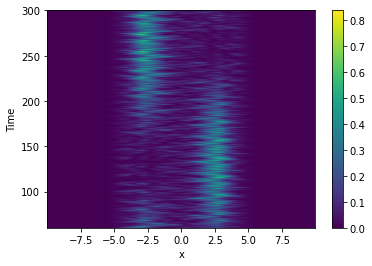

In [73]:
## PLOT SIMULATION ##

pde.plot_kymograph(storage_sim, scalar='norm_squared')

In [74]:
from tqdm.notebook import tqdm

def my_pbar(curr_frame, tot_frame):
    pbar.update(100*curr_frame/tot_frame)

In [75]:
## GENERATE MOVIE ##

# set backend to nbagg for better movie quality
%matplotlib nbagg

sindy_sim = storage_sim.data
times = storage_sim.times

# use only a part of the points for movie
frac = len(times)/1000

fig,ax = plt.subplots()

ax.set_xlabel('x')
ax.set_ylabel(r"$|\psi|^2$")
title = ax.set_title('', y=1.05)
line1, = ax.plot(x, np.abs(sindy_sim[0])**2, "k--", label="SINDy")
line2, = ax.plot(x, np.abs(u[train_sample])**2, "b", label="original")
 
plt.legend(loc=1, fontsize=8, fancybox=False)


def init():
    return line1, line2


def animate(i):
    ax.set_facecolor('white')
    line1.set_data(x, np.abs(sindy_sim[i])**2)
    line2.set_data(x, np.abs(u[i+train_sample])**2)
    title.set_text('Time = {0:1.3f}'.format(times[i]))
    return line1, line2


anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1, blit=True,frames=np.arange(0,len(times),int(frac)))

writer = animation.FFMpegWriter(fps=30, bitrate=-1)


print("Generating animation ...")
pbar = tqdm(total=(len(times)-1)*50/frac)
anim.save(f'./Data/Simulation_video/double_well_xs_{x_s:.3f}_d_{d:.3f}_mu_{mu:.1f}.mov', writer=writer, dpi=150, progress_callback=my_pbar)
pbar.close()
print("Done")

# reset backend to inline
%matplotlib inline


<IPython.core.display.Javascript object>

Generating animation ...


  0%|          | 0/49997.916753468606 [00:00<?, ?it/s]

Done


In [76]:
## VISUALIZE MOVIE ##

Video(f'./Data/Simulation_video/double_well_xs_{x_s:.3f}_d_{d:.3f}_mu_{mu:.1f}.mov')

Probability conserved: True


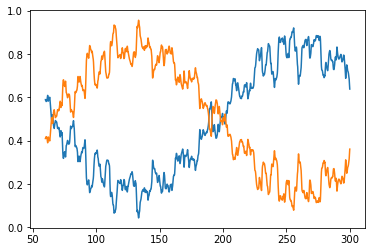

In [77]:
sindy_sim = np.array(sindy_sim)
# compute psi_squared
prob = np.abs(sindy_sim**2)

# compute probability of finding particle on the left or right of the maximum
left_prob = prob[:, x<=0].sum(axis=1)*dx
right_prob = prob[:, x>0].sum(axis=1)*dx

# check if total prob is conserved
print('Probability conserved:', np.allclose(np.ones_like(left_prob), left_prob+right_prob))

plt.plot(times, left_prob)
plt.plot(times, right_prob)

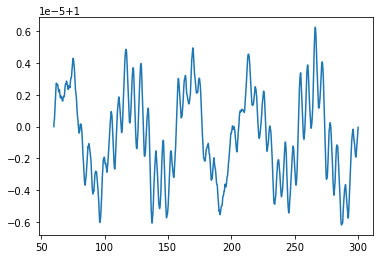

In [78]:
plt.plot(times, prob.sum(axis=1)*dx)

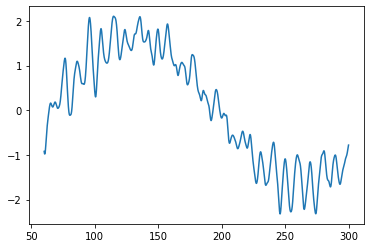

In [79]:
avg_x = np.sum(prob*x, axis=1)*dx
plt.plot(times, avg_x)